### Import Libraries and Data

In [1]:
%%capture
%cd ..

In [2]:
from examples.make_sample_data import make_forest_cover_data
from OrderedOVRClassifier.classifier import OrderedOVRClassifier
from OrderedOVRClassifier.oovr_utils import extended_classification_report

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [3]:
train_df, test_df = make_forest_cover_data()

### Modeling

In [4]:
model_dict = {2: RandomForestClassifier(n_estimators=100),
              6: DecisionTreeClassifier(min_samples_split=4, criterion='entropy'),
              5: ExtraTreesClassifier(n_estimators=100),
              'final': LGBMClassifier(n_estimators=100)}

model_fit_params = {'final': {'verbose': 10}}

oovr = OrderedOVRClassifier(target='Cover_Type',
                            ovr_vals=[2, 6, 5],
                            model_dict=model_dict,
                            model_fit_params=model_fit_params)

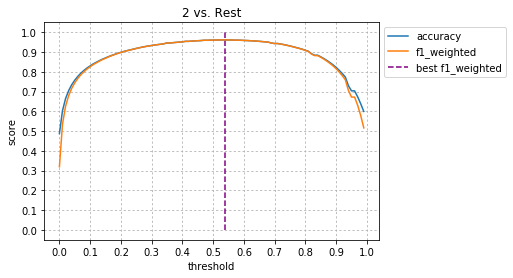

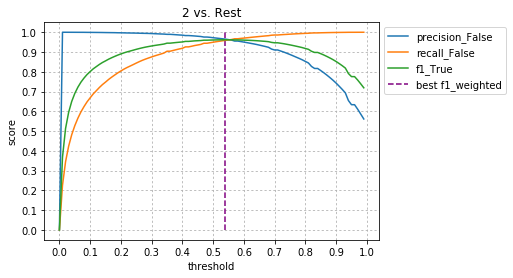

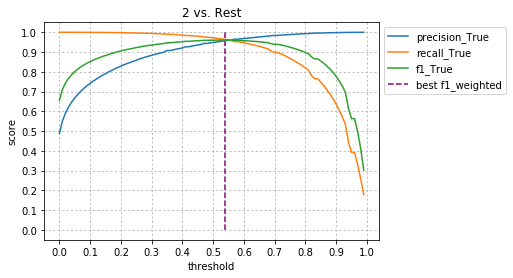

--------------------------------------------------------------------------------
best_threshold: 0.54
pred_cnt: 71293
true_cnt: 70825 

             precision    recall  f1-score   support  n_predictions

      False      0.965     0.959     0.962     74428          73960
       True      0.957     0.964     0.960     70825          71293

avg / total      0.961     0.961     0.961    145253


accuracy: 0.961240043235


--------------------------------------------------------------------------------
finished Ordered OVR fit for value: 2
--------------------------------------------------------------------------------



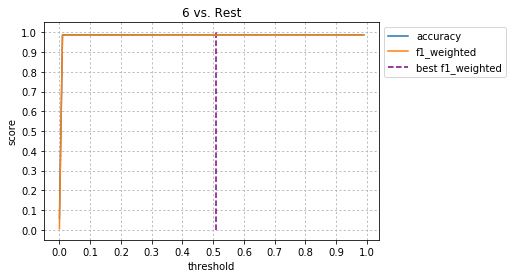

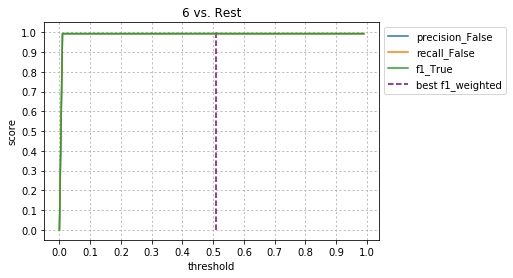

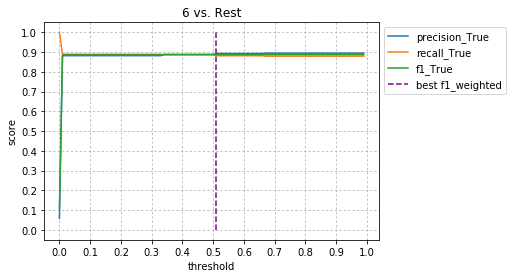

--------------------------------------------------------------------------------
best_threshold: 0.51
pred_cnt: 4287
true_cnt: 4342 

             precision    recall  f1-score   support  n_predictions

      False      0.993     0.993     0.993     70086          70141
       True      0.892     0.881     0.887      4342           4287

avg / total      0.987     0.987     0.987     74428


accuracy: 0.986873219756


--------------------------------------------------------------------------------
finished Ordered OVR fit for value: 6
--------------------------------------------------------------------------------



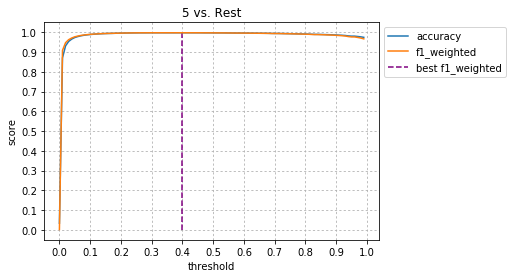

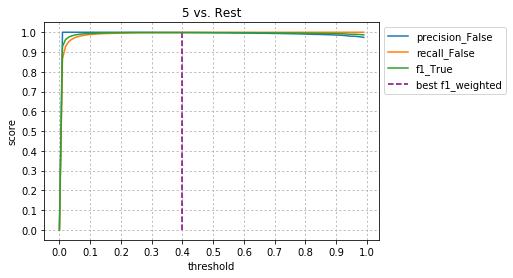

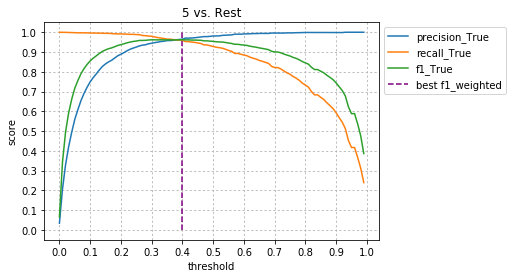

--------------------------------------------------------------------------------
best_threshold: 0.4
pred_cnt: 2359
true_cnt: 2373 

             precision    recall  f1-score   support  n_predictions

      False      0.999     0.999     0.999     67713          67727
       True      0.965     0.959     0.962      2373           2359

avg / total      0.997     0.997     0.997     70086


accuracy: 0.997431726736


--------------------------------------------------------------------------------
finished Ordered OVR fit for value: 5
--------------------------------------------------------------------------------



/Users/athai/anaconda/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/athai/anaconda/lib/python2.7/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.487395
[20]	valid_0's multi_logloss: 0.235777
[30]	valid_0's multi_logloss: 0.13944
[40]	valid_0's multi_logloss: 0.0967293
[50]	valid_0's multi_logloss: 0.0765711
[60]	valid_0's multi_logloss: 0.0653328
[70]	valid_0's multi_logloss: 0.057889
[80]	valid_0's multi_logloss: 0.0528829
[90]	valid_0's multi_logloss: 0.0490085
[100]	valid_0's multi_logloss: 0.0457318

--------------------------------------------------------------------------------
             precision    recall  f1-score   support  n_predictions

        1.0      0.989     0.995     0.992     52960          53269
        3.0      0.989     0.995     0.992      8938           8988
        4.0      0.928     0.862     0.894       687            638
        7.0      0.947     0.889     0.917      5128           4818

avg / total      0.985     0.986     0.985     67713


accuracy: 0.985689601701

-------------------------------------

OrderedOVRClassifier(fbeta_weight=1.0,
           model_dict={2: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight....0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)},
           model_fit_params={2: {}, 'final': {'verbose': 10}, 6: {}, 5: {}},
           ovr_vals=[2, 6, 5], target='Cover_Type', train_final_model=True,
           train_final_only=False)

In [5]:
oovr.fit(train_df, eval_set=test_df)

### Plot Feature Importance

Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
Multiprocessing failed, going single process


[54/54] features ████████████████████ Time elapsed: 57 seconds

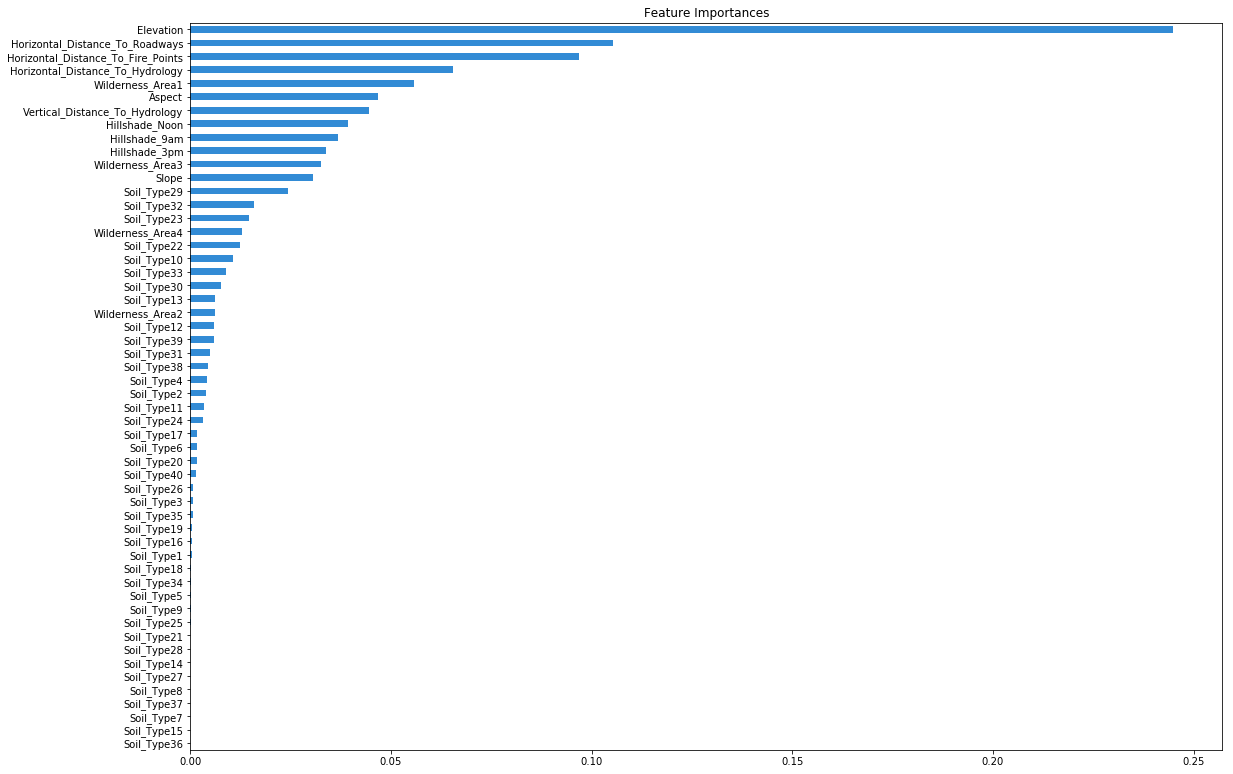

In [6]:
oovr.plot_feature_importance(train_df)

### Plot Partial Dependence

Progress bars slow down runs by 10-20%. For slightly faster runs, do progressbar=False


[100/100] grid cells ████████████████████ Time elapsed: 14 seconds

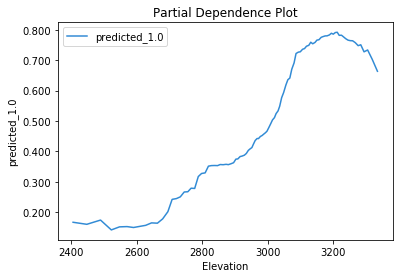

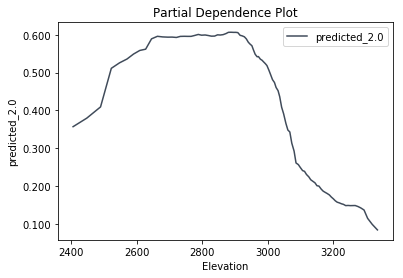

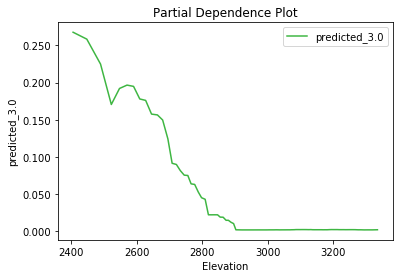

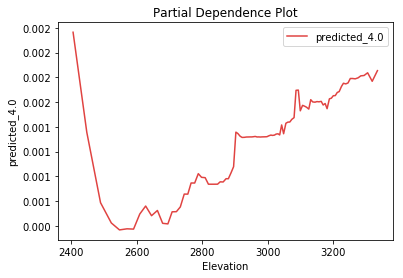

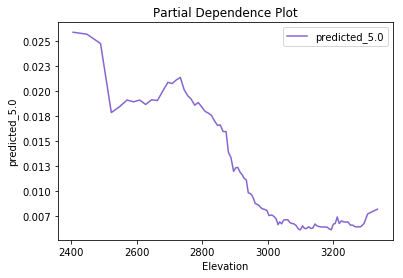

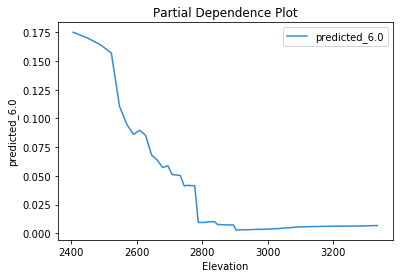

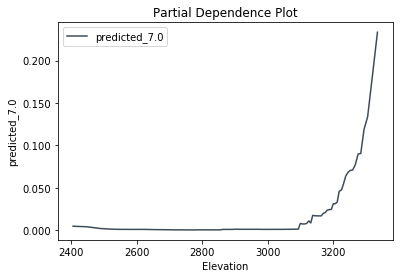

In [7]:
oovr.plot_partial_dependence(train_df, 'Elevation')

### Plot Metric Dependencies vs. Thresholds

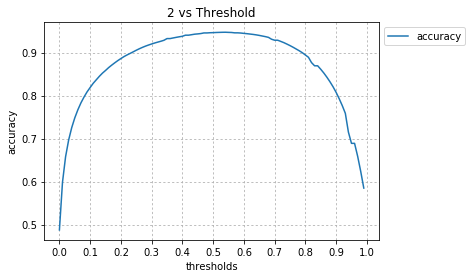

/Users/athai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


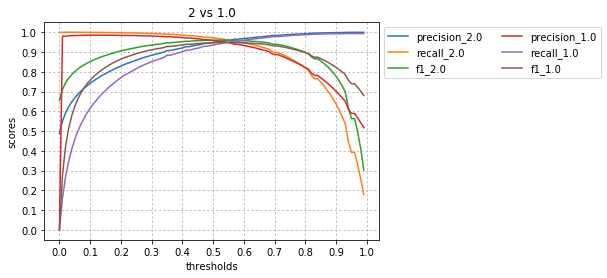

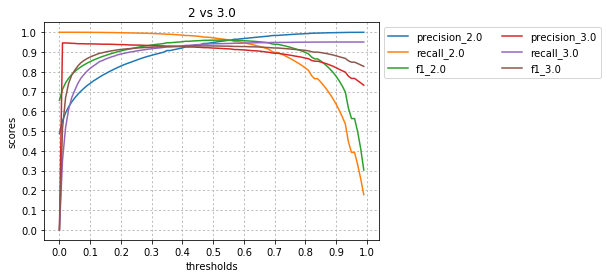

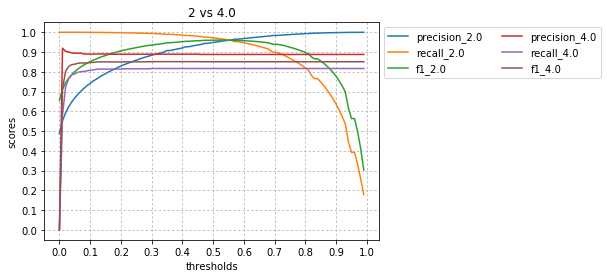

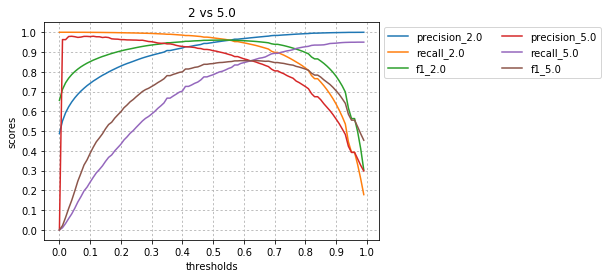

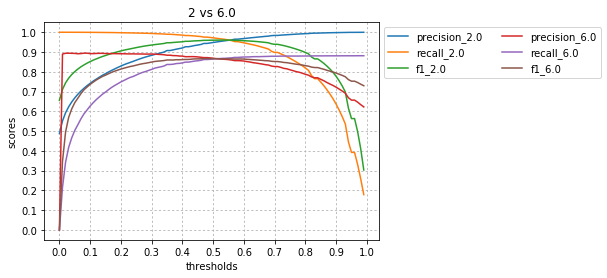

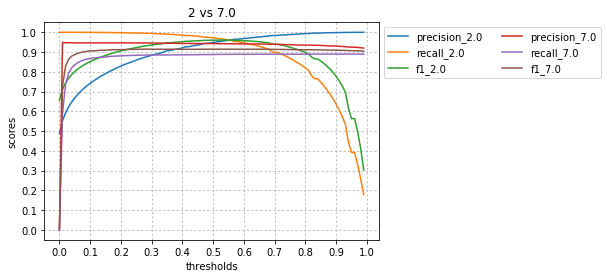

In [8]:
oovr.plot_oovr_dependencies(2, test_df)

### Test and Attach Models

In [9]:
model_dict = {2: RandomForestClassifier(n_estimators=100),
              6: DecisionTreeClassifier(min_samples_split=4, criterion='entropy'),
              5: ExtraTreesClassifier(n_estimators=100)}

model_fit_params = {'final': {'verbose': 10}}

oovr = OrderedOVRClassifier(target='Cover_Type',
                            ovr_vals=[2, 6, 5],
                            model_dict=model_dict,
                            model_fit_params=model_fit_params,
                            train_final_model=False)

In [10]:
%%capture
oovr.fit(train_df, eval_set=test_df)

**Grid Search**

In [11]:
est_lgb = LGBMClassifier()

grid = {'num_leaves': [31, 127, 250],
        'min_child_samples': [5, 20, 35],
        'colsample_bytree': [0.8, 1.0],
        'subsample': [0.8, 1.0]}

gridm = GridSearchCV(est_lgb, grid, scoring='neg_log_loss')

In [12]:
results = oovr.fit_test_grid(gridm, train_df, eval_set=test_df)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492884
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492652
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.457457
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.456819
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.443837
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.443296
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492888
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492652
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.457727
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss:

**Attach Model**

In [13]:
best_lgb = LGBMClassifier(n_estimators=100, num_leaves=250, min_child_samples=5,
                          colsample_bytree=1.0, subsample=0.8)

final_model = oovr.fit_test(best_lgb, train_df, eval_set=test_df)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.43547
[20]	valid_0's multi_logloss: 0.173615
[30]	valid_0's multi_logloss: 0.0799611
[40]	valid_0's multi_logloss: 0.0433794
[50]	valid_0's multi_logloss: 0.028134
[60]	valid_0's multi_logloss: 0.0215275
[70]	valid_0's multi_logloss: 0.018478
[80]	valid_0's multi_logloss: 0.0171038
[90]	valid_0's multi_logloss: 0.0163904
[100]	valid_0's multi_logloss: 0.0161061

--------------------------------------------------------------------------------
             precision    recall  f1-score   support  n_predictions

        1.0      0.997     0.998     0.998     52960          53018
        3.0      0.991     0.996     0.993      8938           8985
        4.0      0.947     0.882     0.913       687            640
        7.0      0.982     0.971     0.977      5128           5070

avg / total      0.995     0.995     0.995     67713


accuracy: 0.994757284421



In [14]:
oovr.attach_model(final_model)

OrderedOVRClassifier(fbeta_weight=1.0,
           model_dict={2: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)},
           model_fit_params={2: {}, 'final': {'verbose': 10}, 6: {}, 5: {}},
           ovr_vals=[2, 6, 5], target='Cover_Type',
           train_final_model=False, train_final_only=False)

In [15]:
y_pred = oovr.predict(test_df)
extended_classification_report(test_df['Cover_Type'], y_pred)

             precision    recall  f1-score   support  n_predictions

        1.0      0.958     0.949     0.954     52960          52466
        2.0      0.957     0.964     0.961     70825          71330
        3.0      0.921     0.943     0.932      8938           9154
        4.0      0.900     0.828     0.863       687            632
        5.0      0.892     0.825     0.857      2373           2195
        6.0      0.863     0.871     0.867      4342           4384
        7.0      0.975     0.968     0.972      5128           5092

avg / total      0.952     0.952     0.952    145253


accuracy: 0.951870185125

